In [ ]:
import torch
import torchvision
import os
import numpy as np
from PIL import Image
!pip install pydicom

import os

%matplotlib inline
import matplotlib.pyplot as plt

!cp /content/drive/MyDrive/DBT/duke_dbt_data.py .
!cp /content/drive/MyDrive/DBT/engine.py .
!cp /content/drive/MyDrive/DBT/coco_utils.py .
!cp /content/drive/MyDrive/DBT/coco_eval.py .
!cp /content/drive/MyDrive/DBT/utils.py .
!cp /content/drive/MyDrive/DBT/transforms.py .

from duke_dbt_data import dcmread_image, read_boxes, draw_box, evaluate
import utils
from engine import train_one_epoch, evaluate

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

!pip install pillow


import torchvision.transforms as TT
import transforms as T


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#training data paths

train_imgs_path = "/content/drive/MyDrive/DBT/lesionImages"
train_labels_path = "/content/drive/MyDrive/DBT/BCS-DBT labels-train-v2.csv"
train_boxes_path = "/content/drive/MyDrive/DBT/BCS-DBT boxes-train-v2.csv"
train_fps_path = "/content/drive/MyDrive/DBT/BCS-DBT file-paths-train-v2.csv"

In [ ]:
df = read_boxes(boxes_fp=train_boxes_path, filepaths_fp=train_fps_path)

In [ ]:
df

,PatientID,StudyUID,View,Subject,Slice,X,Y,Width,Height,Class,AD,VolumeSlices,descriptive_path,classic_path
0,DBT-P00013,DBT-S00163,rmlo,0,16,1116,1724,218,105,benign,0,49,Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00013/1.2.826...
1,DBT-P00024,DBT-S03255,lcc,0,19,267,488,64,64,benign,0,73,Breast-Cancer-Screening-DBT/DBT-P00024/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00024/1.2.826...
2,DBT-P00024,DBT-S03255,lcc,0,37,169,384,93,85,benign,0,73,Breast-Cancer-Screening-DBT/DBT-P00024/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00024/1.2.826...
3,DBT-P00024,DBT-S03255,lmlo,0,11,471,1060,67,56,benign,0,81,Breast-Cancer-Screening-DBT/DBT-P00024/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00024/1.2.826...
4,DBT-P00024,DBT-S03255,lmlo,0,12,640,673,93,80,benign,0,81,Breast-Cancer-Screening-DBT/DBT-P00024/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00024/1.2.826...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,DBT-P05030,DBT-S05569,rmlo,2,24,1465,624,84,115,cancer,0,74,Breast-Cancer-Screening-DBT/DBT-P05030/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P05030/1.2.826...
220,DBT-P05047,DBT-S05588,rcc,0,41,1341,1073,387,499,benign,1,78,Breast-Cancer-Screening-DBT/DBT-P05047/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P05047/1.2.826...
221,DBT-P05047,DBT-S05588,rmlo,0,41,1192,1019,456,541,benign,1,76,Breast-Cancer-Screening-DBT/DBT-P05047/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P05047/1.2.826...
222,DBT-P05056,DBT-S01839,rcc,0,44,1642,661,245,392,cancer,1,72,Breast-Cancer-Screening-DBT/DBT-P05056/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P05056/1.2.826...


In [ ]:
class DBT(torch.utils.data.Dataset):
    def __init__(self, file_dir, transforms, df):
        #root should image folder path
        self.file_dir = file_dir
        self.transforms = transforms
        self.df = df
        self.classes = [_, "lesion"]
        self.imgs = df["descriptive_path"].tolist()
        #volumes have diff views, each bbox on diff view even if same volume

    def __getitem__(self, idx):
        img_path = os.path.join(self.file_dir, self.imgs[idx])
        img_df = df.iloc[idx]
        view = img_df["View"]
        slice_idx = img_df["Slice"]
        image = dcmread_image(fp = img_path, view = view, index = slice_idx)
        norm_image = np.uint8((np.maximum(image,0) / np.max(image)) * 255.0)
        image = Image.fromarray(norm_image)
        #returns PIL.Image.Image
        #int8?

        #may change to just lesions, Check article
        # classes = {
        #     "benign": 1,
        #     "cancer": 2
        # }

        labels = []
        label = 1
        boxes = []
        xmin = img_df["X"]
        ymin = img_df["Y"]
        xmax = xmin + img_df["Width"]
        ymax = ymin + img_df["Height"]
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

        boxes = torch.as_tensor(boxes, dtype = torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # It should be unique between all the images in the dataset, and is used during evaluation
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype = torch.int64) #assuming there is only 1 bbox on each image

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target['fp'] = img_path

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_transforms(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    # transforms.append(T.Resize(100)) #change to scaling
    # should I normalize??
#     if train:

    #!!!!!!!!!should prob downsize images (have to do same to annotations)
    return T.Compose(transforms)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2
#bkgd, lesion

dataset = DBT(train_imgs_path, get_transforms(train = True), df)
dataset_test = DBT(train_imgs_path, get_transforms(train = False), df)

sample_percent = 0.25
sample_size = int(sample_percent*len(dataset))
indices = torch.randperm(sample_size).tolist()
train_split = 0.8
train_num = int((train_split*sample_size))
dataset = torch.utils.data.Subset(dataset, indices[:train_num])
dataset_test = torch.utils.data.Subset(dataset_test, indices[train_num:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 4, shuffle = True, num_workers = 4,
    collate_fn = utils.collate_fn #what does this do?
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size = 4, shuffle = False, num_workers = 4,
    collate_fn = utils.collate_fn
)

In [ ]:
def get_object_detection_model(num_classes, pretrain):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrain) #change pretrained to weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT`

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = torch.load("/content/drive/MyDrive/DBT/modelFull3.pth")

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def inference_transforms(image):
  norm_image = np.uint8((np.maximum(image,0) / np.max(image))*255)
  image = Image.fromarray(norm_image)

  testT = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float),
  ])
  return testT(image), norm_image


In [ ]:
def predict_slice(slice_idx, image_vol):
  image_slice = image_vol[slice_idx, :, :]

  t_image, norm_img = inference_transforms(image_slice)

  with torch.no_grad():
    predictions = model([t_image.to(device)])

  return predictions, norm_img, image_slice, t_image

In [ ]:
img_loader = next(iter(data_loader_test)) # need faster way to load images!

/usr/local/lib/python3.8/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


In [ ]:
img_loader[1]

({'boxes': tensor([[1140, 1353, 1234, 1453]]),
  'labels': tensor([1]),
  'image_id': tensor([24]),
  'area': tensor([9400]),
  'iscrowd': tensor([0]),
  'fp': '/content/drive/MyDrive/DBT/lesionImages/Breast-Cancer-Screening-DBT/DBT-P00538/01-01-2000-DBT-S01986-MAMMO screening digital bilateral-71001/14156.000000-08630/1-1.dcm'},
 {'boxes': tensor([[1411, 1080, 1535, 1172]]),
  'labels': tensor([1]),
  'image_id': tensor([11]),
  'area': tensor([11408]),
  'iscrowd': tensor([0]),
  'fp': '/content/drive/MyDrive/DBT/lesionImages/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/14595.000000-79329/1-1.dcm'},
 {'boxes': tensor([[1415, 1418, 1496, 1503]]),
  'labels': tensor([1]),
  'image_id': tensor([32]),
  'area': tensor([6885]),
  'iscrowd': tensor([0]),
  'fp': '/content/drive/MyDrive/DBT/lesionImages/Breast-Cancer-Screening-DBT/DBT-P00784/01-01-2000-DBT-S05205-MAMMO diagnostic digital bilateral-23673/19377.000000-55830/1-1.dcm'},
 

In [ ]:
idx = 1 # take first img from loader

fp = img_loader[1][idx]["fp"]
image_id = img_loader[1][idx]["image_id"].item()
img_df = df.iloc[image_id]
view = img_df["View"]
slice_num = img_df["VolumeSlices"]
PatientID = img_df["PatientID"]
StudyUID = img_df["StudyUID"]
slice_cancer = img_df["Slice"]

print(fp, image_id, view, slice_num)


/content/drive/MyDrive/DBT/lesionImages/Breast-Cancer-Screening-DBT/DBT-P01139/01-01-2000-DBT-S01170-MAMMO screening digital bilateral-99674/9513.000000-83090/1-1.dcm 45 rmlo 83


In [ ]:
print(slice_cancer)

21


In [ ]:
image_vol = dcmread_image(fp = fp, view = view)

/usr/local/lib/python3.8/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


In [ ]:
prediction, norm_img, not_norm_img, t_image = predict_slice(slice_cancer, image_vol)

In [ ]:
norm_img

array([[  0,   0,   0, ..., 226, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 239],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

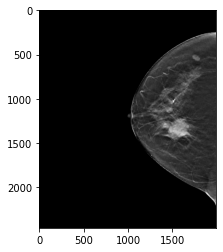

In [ ]:
plt.imshow(not_norm_img, cmap="gray")

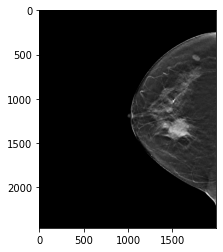

In [ ]:
plt.imshow(norm_img, cmap="gray")

Confidence: 0.5768594145774841


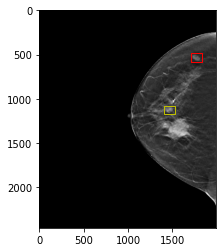

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(img_loader[0][idx][0], cmap = "gray")

#predictions
xmin, ymin, xmax, ymax = prediction[0]["boxes"][0].tolist()
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
score = prediction[0]["scores"][0].item()
print("Confidence:", score)

#ground truth
xmin, ymin, xmax, ymax = img_loader[1][idx]["boxes"][0].tolist()
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='y', facecolor='none')
ax.add_patch(rect)


In [ ]:
 vol_predictions = []

In [ ]:
 for slice_idx in range(5, slice_num-5):
   slice_prediction = predict_slice(slice_idx, image_vol)
   vol_predictions.append(slice_prediction)

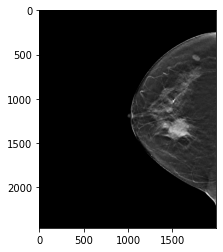

In [ ]:
s_num = 0

fig, ax = plt.subplots()
ax.imshow(img_loader[0][idx][s_num], cmap = "gray")

Confidence:
tensor(0.5102, device='cuda:0')
tensor(0.4790, device='cuda:0')
tensor(0.5077, device='cuda:0')
tensor(0.5066, device='cuda:0')
tensor(0.4998, device='cuda:0')
tensor(0.4979, device='cuda:0')
tensor(0.5032, device='cuda:0')
tensor(0.5537, device='cuda:0')
tensor(0.5229, device='cuda:0')
tensor(0.5291, device='cuda:0')
tensor(0.5401, device='cuda:0')
tensor(0.5194, device='cuda:0')
tensor(0.5269, device='cuda:0')
tensor(0.5394, device='cuda:0')
tensor(0.5591, device='cuda:0')
tensor(0.5725, device='cuda:0')
tensor(0.5769, device='cuda:0')
tensor(0.5793, device='cuda:0')
tensor(0.5778, device='cuda:0')
tensor(0.5885, device='cuda:0')


<ipython-input-125-d423c9f56552>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


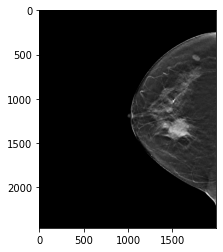

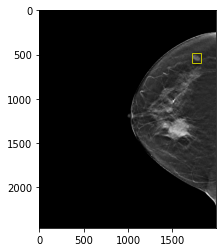

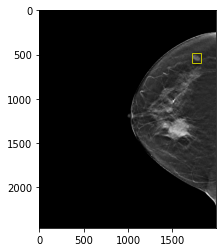

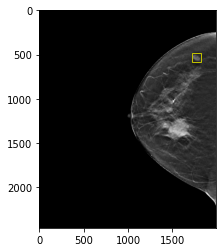

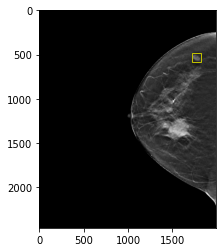

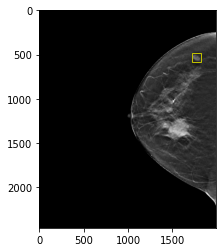

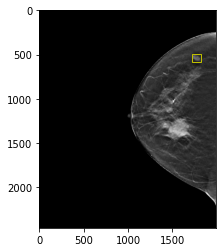

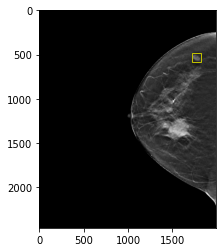

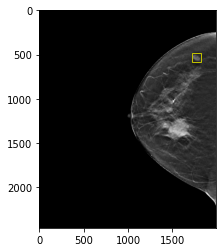

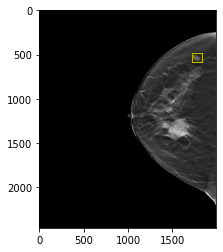

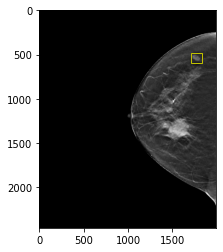

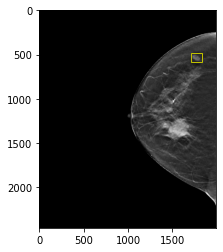

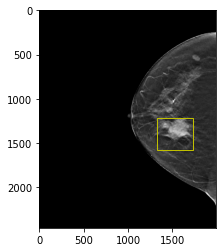

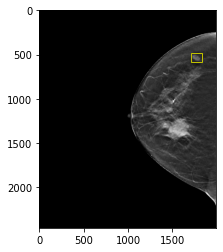

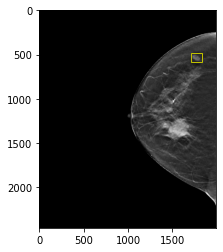

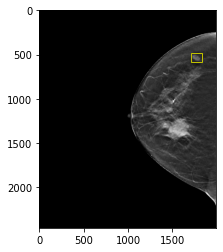

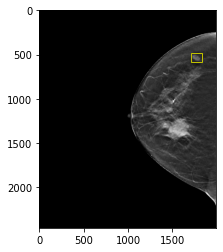

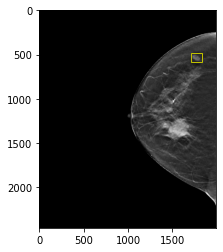

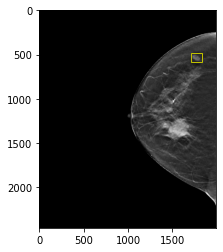

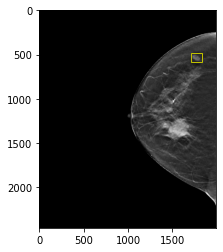

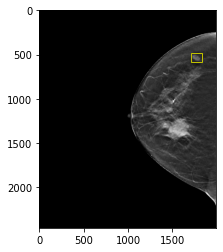

In [ ]:
s_num = 30


fig, ax = plt.subplots()
ax.imshow(img_loader[0][idx][0], cmap = "gray")

#predictions

print("Confidence:")
for i in range(20):
  fig, ax = plt.subplots()
  ax.imshow(img_loader[0][idx][0], cmap = "gray")
  s_num = i
  for box_n in range(1):
    xmin, ymin, xmax, ymax = vol_predictions[s_num][0]["boxes"][box_n].to("cpu")
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='y', facecolor='none')
    ax.add_patch(rect)
    score = vol_predictions[s_num][0]["scores"][box_n]
    print(score)

#ground truth
# xmin, ymin, xmax, ymax = img_loader[1][idx]["boxes"][0].tolist()



In [ ]:
s_num=0


In [ ]:
vol_predictions[s_num][0]["scores"]

tensor([0.5102, 0.4631, 0.4461, 0.3552, 0.3311, 0.3281, 0.3021, 0.2669, 0.2590,
        0.2554, 0.2455, 0.2230, 0.2123, 0.1889, 0.1863, 0.1834, 0.1820, 0.1777,
        0.1765, 0.1736, 0.1715, 0.1609, 0.1592, 0.1509, 0.1389, 0.1318, 0.1244,
        0.1174, 0.1086, 0.1078, 0.1050, 0.0984, 0.0882, 0.0869, 0.0862, 0.0860,
        0.0771, 0.0759, 0.0758, 0.0752, 0.0714, 0.0667, 0.0648, 0.0639, 0.0637,
        0.0624, 0.0590, 0.0572, 0.0543], device='cuda:0')

In [ ]:
 x, y, x2, y2 = vol_predictions[s_num][0]["boxes"][0]

In [ ]:
def NMS_volume(volume_prediction, start_slice, iou_thres, confidence_thres):
  boxes_list = [img_slice[0]["boxes"].to("cpu") for img_slice in vol_predictions]
  scores_list = [img_slice[0]["scores"].to("cpu") for img_slice in vol_predictions]

  boxes_list = torch.cat(boxes_list)
  scores_list = torch.cat(scores_list)

  slice_num_list = []
  for img_slice in vol_predictions:
    for bbox in img_slice[0]["boxes"].tolist():
      slice_num_list.append(start_slice)
    start_slice +=1
  #list of what slice num each bbox is at, correlated w/ idxing

  idxs = torchvision.ops.nms(boxes_list, scores_list, iou_threshold = iou_thres)
  #need to threshold for confidence!!
  keep_idxs = []

  for idx in idxs:
    if scores_list[idx] > confidence_thres:
      keep_idxs.append(idx)

  if len(keep_idxs) > 10:
    keep_idxs = keep_idxs[:10]

  nms_boxes = [boxes_list[idx].tolist() for idx in keep_idxs]
  nms_scores = [scores_list[idx].tolist() for idx in keep_idxs]
  nms_slices = [slice_num_list[idx] for idx in keep_idxs]

  return nms_boxes, nms_scores, nms_slices

In [ ]:
nms_boxesf, nms_scoresf, nms_slicesf = NMS_volume(vol_predictions, 5, 0.2, 0.1)

In [ ]:
nms_boxesf

[[1712.6207275390625,
  475.8610534667969,
  1836.0125732421875,
  597.7725830078125],
 [1402.33935546875, 1180.0592041015625, 1727.731201171875, 1488.06005859375],
 [1385.626220703125, 981.0137939453125, 1576.4739990234375, 1177.9267578125],
 [1495.0667724609375, 971.931640625, 1573.791259765625, 1046.997314453125],
 [1586.6212158203125, 452.6251525878906, 1981.102294921875, 654.8738403320312],
 [1354.1124267578125,
  1237.9686279296875,
  1514.1761474609375,
  1404.05322265625],
 [1079.9757080078125,
  922.233642578125,
  1787.6458740234375,
  1652.1165771484375],
 [1526.1513671875, 1477.0224609375, 1775.84716796875, 1592.8035888671875],
 [1296.617919921875, 1351.093505859375, 1394.576171875, 1442.3038330078125],
 [1344.6641845703125, 855.3820190429688, 1539.71630859375, 1032.994384765625]]

In [ ]:
nms_scoresf

[0.6119094491004944,
 0.5930891633033752,
 0.4486043453216553,
 0.34812694787979126,
 0.3214559257030487,
 0.3040585219860077,
 0.21879824995994568,
 0.1952229142189026,
 0.19340181350708008,
 0.17498524487018585]

In [ ]:
nms_slicesf

[45, 31, 25, 16, 31, 22, 23, 53, 49, 34]

In [ ]:
#fp --> predictions --> evaluate (bypass dataloader)

---

# RUN THIS!!!! MAIN CODING PIPELINE




In [ ]:
import csv

In [ ]:
train_num

44

In [ ]:
training_idxs = indices[:10]
training_df = df.iloc[training_idxs]

In [ ]:
predictions_path = "/content/drive/MyDrive/DBT/predictions4.csv"

In [ ]:
with open(predictions_path, 'w+', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['PatientID','StudyUID','View','X','Width','Y','Height','Z','Depth','Score'])

In [ ]:
def write_csv(PatientID, StudyUID, view, x, width, y, height, Z, depth, score):
  with open(predictions_path, 'a+', newline='') as file:
      writer = csv.writer(file)
      print(PatientID, StudyUID, view, x, width, y, height, Z, depth, score)
      writer.writerow([PatientID, StudyUID, view, int(x), int(width), int(y), int(height), int(Z), int(depth), score])


In [ ]:
#hyperparameters
start_slice = 5
nms_min_iou = 0.5
confidence_thres = 0.1

In [ ]:
for index,view_series in test_df.iterrows():
    view = view_series["View"]
    # if you have image data saved in classic path folder structure, read the file path from "classic_path"
    # image_path = os.path.join("/data", view_series["classic_path"])
    image_path = os.path.join(train_imgs_path, view_series["descriptive_path"])
    PatientID = view_series["PatientID"]
    StudyUID = view_series["StudyUID"]
    VolumeSlices = view_series["VolumeSlices"]

    image_vol = dcmread_image(fp=image_path, view=view)

    vol_predictions = []

    for slice_idx in range(start_slice, VolumeSlices-start_slice):
      slice_prediction = predict_slice(slice_idx, image_vol)
      vol_predictions.append(slice_prediction)

    nms_boxes, nms_scores, nms_slices = NMS_volume(vol_predictions, start_slice, nms_min_iou, confidence_thres)

    num_pred = len(nms_boxes)
    for i in range(num_pred):
      x = int(nms_boxes[i][0])
      width = int(nms_boxes[i][2] - nms_boxes[i][0])
      y = int(nms_boxes[i][1])
      height = int(nms_boxes[i][3] - nms_boxes[i][1])
      Z = int(nms_slices[i])
      depth = 0 #doesn't matter for metrics; Depth is used with Z (first Z coord of bbox) to find the central predicted slice (Z + depth/2).

      write_csv(PatientID, StudyUID, view, x, width, y, height, Z, depth, nms_scores[i])

DBT-P00107 DBT-S05365 lmlo 207 92 1409 107 27 0 0.4527512490749359
DBT-P00107 DBT-S05365 lmlo 164 411 912 215 43 0 0.4392378032207489
DBT-P00107 DBT-S05365 lmlo 198 107 1450 54 17 0 0.3885234296321869
DBT-P00107 DBT-S05365 lmlo 206 105 1354 202 32 0 0.37112560868263245
DBT-P00107 DBT-S05365 lmlo 80 181 876 182 61 0 0.3614312410354614
DBT-P00107 DBT-S05365 lmlo 147 382 1623 324 51 0 0.3558848798274994
DBT-P00107 DBT-S05365 lmlo 268 177 935 167 37 0 0.35558226704597473
DBT-P00107 DBT-S05365 lmlo 29 315 798 309 60 0 0.32729604840278625
DBT-P00107 DBT-S05365 lmlo 68 242 1395 117 17 0 0.3158048391342163
DBT-P00107 DBT-S05365 lmlo 190 98 1698 48 14 0 0.3097238540649414
DBT-P01110 DBT-S04109 lmlo 514 121 1174 103 19 0 0.5533401370048523
DBT-P01110 DBT-S04109 lmlo 482 169 1145 154 18 0 0.4830552935600281
DBT-P01110 DBT-S04109 lmlo 264 64 1296 81 43 0 0.4144175052642822
DBT-P01110 DBT-S04109 lmlo 506 107 1157 89 18 0 0.36692899465560913
DBT-P01110 DBT-S04109 lmlo 492 182 1177 181 18 0 0.3292070

In [ ]:
with open(predictions_path, newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['PatientID', 'StudyUID', 'View', 'X', 'Width', 'Y', 'Height', 'Z', 'Depth', 'Score']
['DBT-P00654', 'DBT-S02571', 'lcc', '732', '95', '1031', '97', '13', '0', '0.4999328851699829']
['DBT-P00654', 'DBT-S02571', 'lcc', '323', '97', '735', '89', '20', '0', '0.46814629435539246']
['DBT-P00654', 'DBT-S02571', 'lcc', '821', '197', '1459', '190', '56', '0', '0.4020325541496277']
['DBT-P00654', 'DBT-S02571', 'lcc', '322', '111', '902', '56', '25', '0', '0.3958861827850342']
['DBT-P00654', 'DBT-S02571', 'lcc', '703', '255', '1590', '123', '13', '0', '0.36124128103256226']
['DBT-P00654', 'DBT-S02571', 'lcc', '704', '116', '1675', '60', '15', '0', '0.35419970750808716']
['DBT-P00654', 'DBT-S02571', 'lcc', '767', '202', '847', '191', '45', '0', '0.31848329305648804']
['DBT-P00654', 'DBT-S02571', 'lcc', '606', '89', '1876', '94', '24', '0', '0.3157699406147003']
['DBT-P00654', 'DBT-S02571', 'lcc', '77', '115', '1977', '200', '8', '0', '0.29767489433288574']
['DBT-P00654', 'DBT-S02571', 'lcc', '817

In [ ]:
from duke_dbt_data import evaluate as evaluate_predictions

In [ ]:
evaluation = evaluate_predictions(train_labels_path, train_boxes_path, predictions_path)

In [ ]:
evaluation # on testing using min iou =0.5, confid = 0.1

{'sensitivity_at_2_fps_all': 0.05357142857142857,
 'sensitivity_at_1_fps_positive': 0.049107142857142856,
 'sensitivity_at_2_fps_positive': 0.05357142857142857,
 'sensitivity_at_3_fps_positive': 0.05357142857142857,
 'sensitivity_at_4_fps_positive': 0.05357142857142857,
 'mean_sensitivity_positive': 0.052455357142857144}

In [ ]:
evaluation = evaluate_predictions(train_labels_path, train_boxes_path, "/content/drive/MyDrive/DBT/predictions4.csv")

In [ ]:
evaluation

{'sensitivity_at_2_fps_all': 0.022321428571428572,
 'sensitivity_at_1_fps_positive': 0.022321428571428572,
 'sensitivity_at_2_fps_positive': 0.022321428571428572,
 'sensitivity_at_3_fps_positive': 0.022321428571428572,
 'sensitivity_at_4_fps_positive': 0.022321428571428572,
 'mean_sensitivity_positive': 0.022321428571428572}

In [ ]:
evaluation = evaluate_predictions(train_labels_path, train_boxes_path, "/content/drive/MyDrive/DBT/predictions4.csv")
evaluation

{'sensitivity_at_2_fps_all': 0.044642857142857144,
 'sensitivity_at_1_fps_positive': 0.044642857142857144,
 'sensitivity_at_2_fps_positive': 0.044642857142857144,
 'sensitivity_at_3_fps_positive': 0.044642857142857144,
 'sensitivity_at_4_fps_positive': 0.044642857142857144,
 'mean_sensitivity_positive': 0.044642857142857144}

***##IGNORE EVERYTHING BELOW THIS *LINE****
---


In [ ]:
for i in range(num_pred):
  print(PatientID, StudyUID, view, nms_boxesf[i][0], nms_boxesf[i][1], nms_boxesf[i][2] - nms_boxesf[i][0], nms_boxesf[i][3] - nms_boxesf[i][1], nms_slicesf[i], 0, nms_scoresf[i])

DBT-P00654 DBT-S02571 lcc 732.84375 1031.5845947265625 95.00048828125 97.667236328125 13 0 0.4999328851699829
DBT-P00654 DBT-S02571 lcc 323.3829040527344 735.9171142578125 97.30685424804688 89.112548828125 20 0 0.46814629435539246
DBT-P00654 DBT-S02571 lcc 821.227783203125 1459.8712158203125 197.63592529296875 190.4873046875 56 0 0.4020325541496277
DBT-P00654 DBT-S02571 lcc 322.69976806640625 902.20458984375 111.12576293945312 56.36865234375 25 0 0.3958861827850342
DBT-P00654 DBT-S02571 lcc 703.8046875 1590.2154541015625 255.66387939453125 123.2039794921875 13 0 0.36124128103256226
DBT-P00654 DBT-S02571 lcc 704.877197265625 1675.92236328125 116.7738037109375 60.1904296875 15 0 0.35419970750808716
DBT-P00654 DBT-S02571 lcc 767.0934448242188 847.1218872070312 202.99932861328125 191.60821533203125 45 0 0.31848329305648804
DBT-P00654 DBT-S02571 lcc 606.7492065429688 1876.6448974609375 89.92010498046875 94.382080078125 24 0 0.3157699406147003
DBT-P00654 DBT-S02571 lcc 77.89289093017578 1977

In [ ]:
boxes_list = [img_slice[0]["boxes"] for img_slice in vol_predictions]

In [ ]:
boxes_list

[tensor([[ 179.5653,  715.7635,  414.8614,  833.6579],
         [ 734.7480, 1029.5254,  827.5989, 1127.5022],
         [ 410.0547, 1399.9008,  521.7151, 1495.1881],
         [ 312.5464,  753.0298,  404.6711,  805.0231],
         [ 322.6147,  731.4526,  414.5259,  821.6743],
         [ 160.6144,  600.8611,  473.7778,  912.9095],
         [ 749.2139,  991.0844,  811.4195, 1119.9596],
         [ 749.0975, 1059.1666,  831.0309, 1116.3922],
         [ 198.3479,  686.1417,  434.4961,  795.5050],
         [ 393.0070, 1376.1483,  499.9997, 1472.2139],
         [ 770.1155,  726.3162,  988.2712, 1060.9154],
         [ 723.8770,  976.1339,  833.2392, 1165.9447],
         [ 607.7661, 1432.4495,  989.2810, 1767.4332],
         [ 372.8783, 1383.2179,  582.8452, 1494.5490],
         [ 282.3559,  712.8943,  441.0655,  871.0406],
         [ 748.1461, 1046.8948,  810.7405, 1162.5217],
         [ 114.4533, 1977.3612,  274.2349, 2134.6794]], device='cuda:0'),
 tensor([[ 735.5259, 1029.7550,  826.3414, 112

In [ ]:
scores_list = [img_slice[0]["scores"] for img_slice in vol_predictions]

In [ ]:
boxes_list = torch.cat(boxes_list, 0)

In [ ]:
slice_num_list = []

In [ ]:
len(vol_predictions[0][0]["boxes"].tolist())

49

In [ ]:
slice_idx_i = 5
for img_slice in vol_predictions:
  for bbox in img_slice[0]["boxes"].tolist():
    slice_num_list.append(slice_idx_i)
  slice_idx_i +=1

In [ ]:
[idx.item() for idx in idxs]

[1883, 1221, 936, 2019, 2200, 2025, 1186, 1242, 585, 78, 1112, 507, 2229]

In [ ]:
nms_slices = [slice_num_list[idx.item()] for idx in idxs]

In [ ]:
nms_slices

[45, 31, 25, 49, 53, 49, 30, 31, 17, 6, 28, 15, 53]

In [ ]:
nms_boxes = [boxes_list[idx.item()].tolist() for idx in idxs]

In [ ]:
nms_scores = [scores_list[idx.item()].tolist() for idx in idxs]

In [ ]:
vol_predictions[0][0]["boxes"][0]

tensor(0.5100, device='cuda:0')

In [ ]:
len(vol_predictions)

49

In [ ]:
img_loader[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.9529, 0.9529, 0.9686],
          [0.0000, 0.0000, 0.0000,  ..., 0.9098, 0.8980, 0.8980],
          [0.0000, 0.0000, 0.0000,  ..., 0.8000, 0.8549, 0.8431],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.9529, 0.9294, 0.8902],
          [0.0000, 0.0000, 0.0000,  ..., 0.9961, 0.9686, 0.9451],
          [0.0000, 0.0000, 0.0000,  ..., 0.9765, 0.9961, 0.9765]]]),
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.843

In [ ]:
img_slices_show

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 

In [ ]:
img_slices_show = [image_vol[idx] for idx in nms_slices]

In [ ]:
image_vol[nms_slices[idx]]

In [ ]:
start_slice = 5
iou_thres = 0.05
confidence_thres = 0.1


In [ ]:
vol_predictions[0][0]["boxes"].to("cpu")

tensor([[1720.9047,  485.6419, 1825.5282,  590.1865],
        [1370.1980, 1188.5872, 1741.7871, 1528.7351],
        [1699.8611,  445.6273, 1851.5195,  598.1678],
        [1433.6680,  955.7693, 1601.4164, 1121.8394],
        [1459.4528,  981.8607, 1559.5331, 1077.7661],
        [1388.9075,  981.7802, 1573.8469, 1171.4956],
        [1662.3774,  487.9780, 1890.2516,  625.0474],
        [1444.2662, 1214.9078, 1672.5905, 1649.5093],
        [1677.9784,  445.5359, 1811.3397,  668.2880],
        [1727.0049,  509.4622, 1817.1855,  567.4526],
        [1217.0319, 1205.0336, 1684.7639, 1434.5232],
        [1315.8473,  961.5623, 1693.8508, 1182.1251],
        [1467.9329, 1120.6461, 1788.5637, 1440.7048],
        [1410.0454,  850.8473, 1615.1604, 1227.6736],
        [1721.7086,  461.3087, 1859.2795,  696.3490],
        [1663.1678,  389.1825, 1861.7241,  756.1737],
        [1436.0922, 1010.7576, 1558.5217, 1248.0956],
        [1438.3408, 1329.9506, 1698.7148, 1457.2671],
        [1346.6913, 1062.609

In [ ]:
boxes_list = [img_slice[0]["boxes"].to('cpu') for img_slice in vol_predictions]
scores_list = [img_slice[0]["scores"].to('cpu') for img_slice in vol_predictions]

In [ ]:
torch.cat(boxes_list)

tensor([[ 179.5653,  715.7635,  414.8614,  833.6579],
        [ 734.7480, 1029.5254,  827.5989, 1127.5022],
        [ 410.0547, 1399.9008,  521.7151, 1495.1881],
        ...,
        [ 936.4827, 1162.9861, 1036.2103, 1255.0719],
        [ 848.1586, 1411.6869, 1035.0037, 1590.0686],
        [ 905.5455, 1133.1316, 1137.9843, 1263.2852]])

In [ ]:
slice_num_list = []
for img_slice in vol_predictions:
  for bbox in img_slice[0]["boxes"].tolist():
    slice_num_list.append(start_slice)
  start_slice +=1

In [ ]:
torchvision.ops.nms(boxes_list, scores_list, 0.1)

RuntimeError: ignored

In [ ]:
idxs = torchvision.ops.nms(boxes_list.to("cpu"), scores_list.to("cpu"), iou_threshold =0.01).tolist()
#need to threshold for confidence!!
keep_idxs = []

AttributeError: ignored

In [ ]:
nms_boxesf, nms_slicesf, nms_slicesf = NMS_volume(vol_predictions, 5, 0.01, 0.1)

RuntimeError: ignored

Confidence: 0.6118864417076111
Confidence: 0.5930795669555664
Confidence: 0.44860711693763733
Confidence: 0.29579582810401917
Confidence: 0.19599801301956177
Confidence: 0.1935199648141861
Confidence: 0.16584497690200806
Confidence: 0.1561385691165924
Confidence: 0.15516303479671478
Confidence: 0.11942949146032333
Confidence: 0.09040816128253937
Confidence: 0.06547500193119049
Confidence: 0.05173075944185257


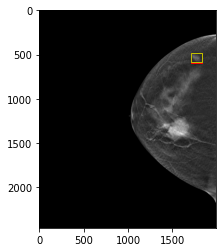

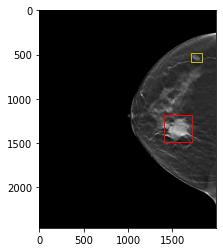

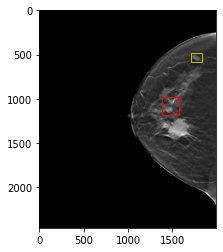

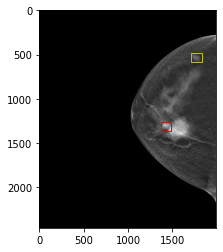

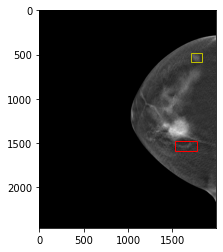

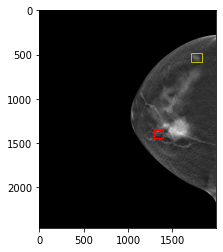

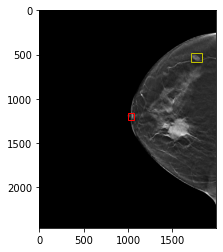

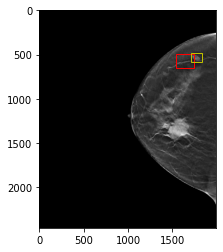

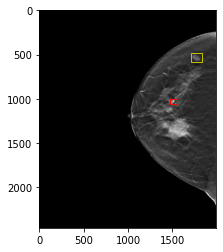

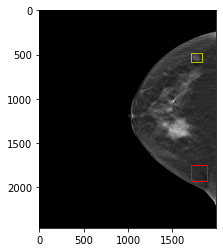

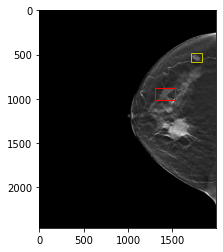

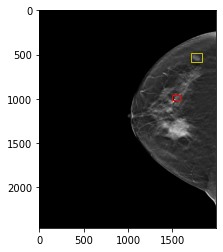

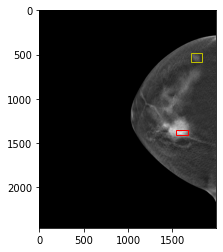

In [ ]:
import matplotlib.patches as patches

#predictions

for i, idx in enumerate(idxs):
  fig, ax = plt.subplots()
  plt.imshow(image_vol[nms_slices[i]], cmap = "gray")
  xmin, ymin, xmax, ymax = boxes_list[idx].tolist()
  rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  score = scores_list[idx].item()
  print("Confidence:", score)

  #ground truth
  xmin, ymin, xmax, ymax = img_loader[1][0]["boxes"][0].tolist()
  rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='y', facecolor='none')
  ax.add_patch(rect)



In [ ]:
slice_num_list = [for img_slice in vol_predictions]

In [ ]:
scores_list = torch.cat(scores_list, 0)


In [ ]:
idxs = torchvision.ops.nms(torch.Tensor(boxes_list), torch.Tensor(scores_list), iou_threshold = 0.1)

ValueError: ignored

In [ ]:
idxs #need to find what slice these are in

tensor([1883, 1221,  936, 2019, 2200, 2025, 1186, 1242,  585,   78, 1112,  507,
        2229], device='cuda:0')

In [ ]:
vol_predictions[0][0]["boxes"][0]

tensor([1720.9047,  485.6419, 1825.5282,  590.1865], device='cuda:0')

In [ ]:
for img_slice in vol_predictions:
  boxes_list.extend(img_slice[0]["boxes"].to("cpu"))

In [ ]:
for img_slice in vol_predictions:
  scores_list.extend(img_slice[0]["scores"].to("cpu"))

In [ ]:
len(boxes_list), len(scores_list)

(2233, 2233)

In [ ]:
vol_predictions[0]

[{'boxes': tensor([[1720.9047,  485.6419, 1825.5282,  590.1865],
          [1370.1980, 1188.5872, 1741.7871, 1528.7351],
          [1699.8611,  445.6273, 1851.5195,  598.1678],
          [1433.6680,  955.7693, 1601.4164, 1121.8394],
          [1459.4528,  981.8607, 1559.5331, 1077.7661],
          [1388.9075,  981.7802, 1573.8469, 1171.4956],
          [1662.3774,  487.9780, 1890.2516,  625.0474],
          [1444.2662, 1214.9078, 1672.5905, 1649.5093],
          [1677.9784,  445.5359, 1811.3397,  668.2880],
          [1727.0049,  509.4622, 1817.1855,  567.4526],
          [1217.0319, 1205.0336, 1684.7639, 1434.5232],
          [1315.8473,  961.5623, 1693.8508, 1182.1251],
          [1467.9329, 1120.6461, 1788.5637, 1440.7048],
          [1410.0454,  850.8473, 1615.1604, 1227.6736],
          [1721.7086,  461.3087, 1859.2795,  696.3490],
          [1663.1678,  389.1825, 1861.7241,  756.1737],
          [1436.0922, 1010.7576, 1558.5217, 1248.0956],
          [1438.3408, 1329.9506, 1698.7

In [ ]:
vol_predictions[0][0]["boxes"]

tensor([[1720.9047,  485.6419, 1825.5282,  590.1865],
        [1370.1980, 1188.5872, 1741.7871, 1528.7351],
        [1699.8611,  445.6273, 1851.5195,  598.1678],
        [1433.6680,  955.7693, 1601.4164, 1121.8394],
        [1459.4528,  981.8607, 1559.5331, 1077.7661],
        [1388.9075,  981.7802, 1573.8469, 1171.4956],
        [1662.3774,  487.9780, 1890.2516,  625.0474],
        [1444.2662, 1214.9078, 1672.5905, 1649.5093],
        [1677.9784,  445.5359, 1811.3397,  668.2880],
        [1727.0049,  509.4622, 1817.1855,  567.4526],
        [1217.0319, 1205.0336, 1684.7639, 1434.5232],
        [1315.8473,  961.5623, 1693.8508, 1182.1251],
        [1467.9329, 1120.6461, 1788.5637, 1440.7048],
        [1410.0454,  850.8473, 1615.1604, 1227.6736],
        [1721.7086,  461.3087, 1859.2795,  696.3490],
        [1663.1678,  389.1825, 1861.7241,  756.1737],
        [1436.0922, 1010.7576, 1558.5217, 1248.0956],
        [1438.3408, 1329.9506, 1698.7148, 1457.2671],
        [1346.6913, 1062.609

In [ ]:
idxs = torchvision.ops.nms(vol_predictions[0][0]["boxes"], vol_predictions[0][0]["scores"], iou_threshold = 0.4)

In [ ]:
#start with 1 slice
slice1_pred_boxes = vol_predictions[0][0]["boxes"]
slice1_pred_scores = vol_predictions[0][0]["scores"]

In [ ]:
vol_predictions[0][1]["boxes"]

IndexError: ignored

In [ ]:
slice1_pred_boxes

tensor([[1720.9047,  485.6419, 1825.5282,  590.1865],
        [1370.1980, 1188.5872, 1741.7871, 1528.7351],
        [1699.8611,  445.6273, 1851.5195,  598.1678],
        [1433.6680,  955.7693, 1601.4164, 1121.8394],
        [1459.4528,  981.8607, 1559.5331, 1077.7661],
        [1388.9075,  981.7802, 1573.8469, 1171.4956],
        [1662.3774,  487.9780, 1890.2516,  625.0474],
        [1444.2662, 1214.9078, 1672.5905, 1649.5093],
        [1677.9784,  445.5359, 1811.3397,  668.2880],
        [1727.0049,  509.4622, 1817.1855,  567.4526],
        [1217.0319, 1205.0336, 1684.7639, 1434.5232],
        [1315.8473,  961.5623, 1693.8508, 1182.1251],
        [1467.9329, 1120.6461, 1788.5637, 1440.7048],
        [1410.0454,  850.8473, 1615.1604, 1227.6736],
        [1721.7086,  461.3087, 1859.2795,  696.3490],
        [1663.1678,  389.1825, 1861.7241,  756.1737],
        [1436.0922, 1010.7576, 1558.5217, 1248.0956],
        [1438.3408, 1329.9506, 1698.7148, 1457.2671],
        [1346.6913, 1062.609

In [ ]:
idxs = torchvision.ops.nms(slice1_pred_boxes, slice1_pred_scores, iou_threshold = 0.4)

In [ ]:
slice1_pred_boxes

tensor([[1720.9047,  485.6419, 1825.5282,  590.1865],
        [1370.1980, 1188.5872, 1741.7871, 1528.7351],
        [1699.8611,  445.6273, 1851.5195,  598.1678],
        [1433.6680,  955.7693, 1601.4164, 1121.8394],
        [1459.4528,  981.8607, 1559.5331, 1077.7661],
        [1388.9075,  981.7802, 1573.8469, 1171.4956],
        [1662.3774,  487.9780, 1890.2516,  625.0474],
        [1444.2662, 1214.9078, 1672.5905, 1649.5093],
        [1677.9784,  445.5359, 1811.3397,  668.2880],
        [1727.0049,  509.4622, 1817.1855,  567.4526],
        [1217.0319, 1205.0336, 1684.7639, 1434.5232],
        [1315.8473,  961.5623, 1693.8508, 1182.1251],
        [1467.9329, 1120.6461, 1788.5637, 1440.7048],
        [1410.0454,  850.8473, 1615.1604, 1227.6736],
        [1721.7086,  461.3087, 1859.2795,  696.3490],
        [1663.1678,  389.1825, 1861.7241,  756.1737],
        [1436.0922, 1010.7576, 1558.5217, 1248.0956],
        [1438.3408, 1329.9506, 1698.7148, 1457.2671],
        [1346.6913, 1062.609

In [ ]:
len(boxes_list)

63

In [ ]:
#depth doesn't matter since you're just outputing the central slice,
# + critieria doesn't call for this

In [ ]:
NMS_volume(boxes_list,scores_list)

NameError: ignored

In [ ]:
for i in range(0, num_slices-5):
  if(len(vol_predictions))

In [ ]:
final_boxes_vol = []
final_scores_vol = []
final_slices_vol = []

In [ ]:
{slice_idx: [{boxes: [], labels: [], scores: []}}

In [ ]:
s_idx = 30
min_iou = 0.05
min_score = 0.01
nms_idxs = torchvision.ops.nms(vol_predictions[s_idx][0]["boxes"], vol_predictions[s_idx][0]["scores"], iou_threshold = min_iou)


In [ ]:
print(vol_predictions.get("boxes"))

None


In [ ]:
nms_idxs

tensor([ 0,  1,  3,  9, 23, 42], device='cuda:0')

In [ ]:
vol_predictions

{5: [{'boxes': tensor([[ 191.0175, 1082.7212,  375.2643, 1257.8838],
           [   0.0000, 1607.9039,  168.5867, 2035.5629]], device='cuda:0'),
   'labels': tensor([1, 1], device='cuda:0'),
   'scores': tensor([0.0773, 0.0715], device='cuda:0')}],
 6: [{'boxes': tensor([[ 191.7031, 1084.5258,  374.3358, 1260.3350],
           [ 160.4283,  381.6027,  242.3382,  466.6535],
           [ 132.4784, 1026.6066,  409.4024, 1315.9481],
           [ 185.6959, 1025.8870,  309.0735, 1241.6577],
           [ 472.9292, 1302.8119,  533.3207, 1423.3488],
           [ 596.4968, 1086.5463,  677.6365, 1162.3931],
           [  10.0884, 1581.3662,  205.8320, 2000.4009],
           [ 130.1127,  338.9950,  284.8139,  493.1463],
           [ 220.6942, 1113.2061,  342.8730, 1330.5240]], device='cuda:0'),
   'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
   'scores': tensor([0.2354, 0.1189, 0.1125, 0.1097, 0.1072, 0.0942, 0.0764, 0.0739, 0.0532],
          device='cuda:0')}],
 7: [{'boxes': t

In [ ]:
vol_predictions[0]

KeyError: ignored

In [ ]:
min_iou = 0.05

In [ ]:
nms_idxs = torchvision.ops.nms(vol_predictions[i]["boxes"], predictions[i]["scores"], iou_threshold = min_iou)


NameError: ignored

In [ ]:
#how to do NMS across all slices???

In [ ]:
torch.cuda.empty_cache()
vol_predictions

[[{'boxes': tensor([[ 441.8073, 1493.8262,  951.2213, 1706.1475],
           [ 569.4003, 1096.4119,  748.6667, 1259.5704],
           [ 435.3630, 1512.8154,  787.2902, 1837.0560],
           [ 515.8928, 1358.2622,  877.1279, 1687.7380],
           [ 593.0812, 1124.2775,  703.3159, 1211.1233],
           [ 149.9828, 1691.2218,  712.2330, 1908.2560],
           [ 506.5291, 1003.1269,  603.8313, 1101.0819],
           [ 528.2422, 1391.2744,  745.9587, 1791.1139],
           [ 498.3912,  988.5101,  660.4146, 1158.0615],
           [ 191.3538, 1545.7816,  610.8654, 1893.0791],
           [ 478.2556, 1080.9226,  800.6744, 1389.0801],
           [ 578.2437, 1558.9004,  852.7401, 1672.5211],
           [   0.0000, 1560.1814,  885.1391, 1957.2101],
           [ 541.2518, 1151.6813,  779.1374, 1272.9996],
           [ 597.7283, 1397.3052,  824.9700, 1797.7927],
           [ 500.5909, 1122.0376,  733.9934, 1233.0984],
           [ 572.8040, 1536.0665,  749.5155, 1698.1383],
           [ 273.6130,